<a href="https://colab.research.google.com/github/aregawi2012/Deep-Learning-Models/blob/master/Simple-MNIST-digits-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data.dataloader as dataloader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.optim as opt
import torch.nn as nn
import torch.optim as optim


In [40]:
# check if there is GPU
gpu_avaliable = torch.cuda.is_available()
if gpu_avaliable:
  device = "cuda"
  print("GPU avaliable train of GPU")
else:
  print("No GPU availabie , training will continue on cpu")

GPU avaliable train of GPU


In [41]:
# Prepare dataset
ts = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.4 , 0.5)])
train = datasets.MNIST('mnist', train=True, transform=ts, download=True)
test  = datasets.MNIST('mnist', train=False, transform=ts, download=True)

In [42]:
train_loader = dataloader.DataLoader(train,batch_size=100 , shuffle=True)
test_loader = dataloader.DataLoader(test,batch_size=100 , shuffle=False)

In [43]:
# VISUALIZATION

(-0.5, 27.5, 27.5, -0.5)

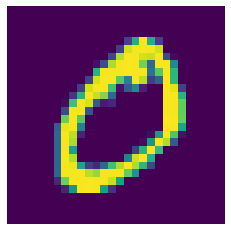

In [44]:
# single image
fig = plt.figure()
plt.imshow(train.data[1,:,:])
plt.axis('off')

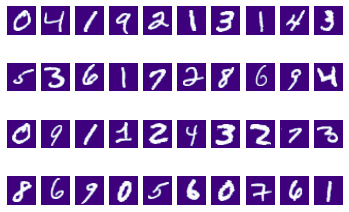

In [45]:
# multiple images
fig = plt.figure()
num_image = 40 
for i in range(1 , 41):
  plt.subplot(4,10,i)
  plt.imshow(train.data[i],cmap='Purples_r' , )
  plt.axis('off')

In [46]:
# Creating Network Architecture
class Network(nn.Module):
  def __init__(self , num_in_channels, num_classes):
    super(Network, self).__init__()

    self.features = nn.Sequential(
           nn.Conv2d(num_in_channels, out_channels=32, kernel_size=3 , padding=1 , stride=1),
           nn.ReLU(),

           nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
           nn.ReLU(),
           nn.MaxPool2d(2),
           nn.Dropout(0.4),

           nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
           nn.ReLU(),
           nn.MaxPool2d(2)

     )
    self.classfier = nn.Sequential(
       nn.Linear(7*7*64, 200),
       nn.ReLU(),
       nn.Dropout(0.5),
       nn.Linear(200,num_classes),
       nn.ReLU()
    )
    
  def forward(self, x):

     # extract features
     x = self.features(x)

     # flatten features
     x = x.view(-1 , 7*7*64)

     # classfier part
     x = self.classfier(x)
     
     return x

In [47]:
# Create the instance of the model
model = Network(1,10)
if gpu_avaliable:
  model = model.to(device)

In [48]:
# we will save checkpoints to the checkpoints folder. Create it.
!mkdir -p checkpoints

In [49]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [50]:


#Loss function 
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.Adam(model.parameters() , lr=3e-4 , weight_decay=0.001)


In [51]:
# define training for epoch

def train_one_epoch():

    # put model in train mode
    model.train()

    # keep track of the training losses during the epoch
    train_losses = []

    for batch, targets in train_loader:
        # Move the training data to the GPU
        if gpu_avaliable:
           batch = batch.to(device)
           targets = targets.to(device)

        #reset gradients
        optimizer.zero_grad()

        # make prediction ( forward pass)
        predictions = model(batch)

        # calculate loss
        loss = criterion(predictions, targets)

        #backprop
        loss.backward()

        #Update weights
        optimizer.step()

        # hold losses
        train_losses.append(loss.item())
    return np.mean(train_losses)

def testing_one_epoch():

  # put model to validation
  model.eval()

  # validation loos
  test_losses = []
  y_pred = []

  # testing stage
  with torch.no_grad():

    # for each batch
    
    for batch , targets in test_loader:

      # add to device if there is special device
      if gpu_avaliable:
        batch = batch.to(device)
        targets = targets.to(device)


      # make prediction
      predictions = model(batch)

      # calculate the loss
      loss = criterion(predictions,targets)

      # update running loss value
      test_losses.append(loss.item())

      # save predictions
      y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

  # avearage testing error for this
  test_loss = np.mean(test_losses)

  # for accuracy ( we need y_hat and y_true)
  y_hat = np.array(y_pred , dtype = np.float32)
  y_true = np.array(test.targets , dtype=np.float32) # all targets
 
  # get accuracy
  accuracy =  np.mean(y_hat == y_true)

  return test_loss , accuracy

In [52]:
# now iterate through all the epoches
def train_model(epochs):

  train_losses, valid_losses , accuracy = [],  [], []
  for epoch in range(epochs):

    # call training
    train_loss = train_one_epoch()

    # call testing after each epoch
    test_loss, acc = testing_one_epoch()

    print(f'[{epoch:03d}] train loss :{train_loss:04f} '
          f'test loss : {test_loss:04f} '
          f'acc: {acc*100:.4f}%')
    
    # track losses for later statestics
    train_losses.append(train_loss)
    valid_losses.append(test_loss)
    accuracy.append(acc)

    # save models
    check_point_name = f'checkpoints/mnist-{epoch:02d}.pkl'
    save_checkpoint(optimizer,model,epoch,check_point_name)

  return train_losses, valid_losses, accuracy
  

In [53]:
train_losses, valid_losses, acc = train_model(15)

[000] train loss :0.523531 test loss : 0.078507 acc: 97.4600%
[001] train loss :0.134407 test loss : 0.057788 acc: 98.1800%
[002] train loss :0.105461 test loss : 0.046300 acc: 98.3900%
[003] train loss :0.085938 test loss : 0.037639 acc: 98.7600%
[004] train loss :0.074895 test loss : 0.036132 acc: 98.8000%
[005] train loss :0.071170 test loss : 0.034659 acc: 98.9400%
[006] train loss :0.062535 test loss : 0.032477 acc: 98.9100%
[007] train loss :0.059489 test loss : 0.027706 acc: 99.1400%
[008] train loss :0.057578 test loss : 0.029677 acc: 99.0800%
[009] train loss :0.054813 test loss : 0.027417 acc: 99.1600%
[010] train loss :0.052029 test loss : 0.025539 acc: 99.1800%
[011] train loss :0.051505 test loss : 0.028117 acc: 99.0300%
[012] train loss :0.047326 test loss : 0.025080 acc: 99.2600%
[013] train loss :0.045944 test loss : 0.025236 acc: 99.1700%
[014] train loss :0.044921 test loss : 0.026956 acc: 99.1900%


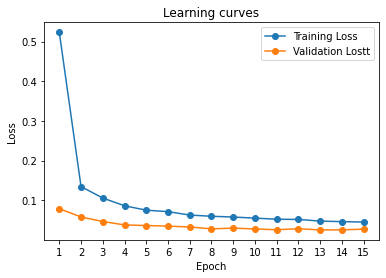

In [59]:
# draw statistics
epochs = range(1,len(train_losses)+1)
fig = plt.figure()
plt.plot(epochs, train_losses ,'-o' , label = "Training Loss")
plt.plot(epochs, valid_losses, '-o' ,label = 'Validation Lostt')
#plt.plot(epochs, acc, '-o' ,label = 'Accuracy')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()


In [61]:
load_checkpoint(optimizer,model,'checkpoints/mnist-14.pkl')

14

In [62]:
# prediction on signle image

image_index = 300 # from the testing set
single_loaded_img = test_loader.dataset.data[image_index]
single_loaded_img = single_loaded_img.to(device)
single_loaded_img = single_loaded_img[None, None]
single_loaded_img = single_loaded_img.type('torch.cuda.FloatTensor') # instead of DoubleTensor

out_predict = model(single_loaded_img)

tensor([[   0.0000,  340.8246,  101.5164,    0.0000, 1420.7695,    0.0000,
            0.0000,  318.6374,    0.0000,   64.9725]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[4]], device='cuda:0')


<function matplotlib.pyplot.show>

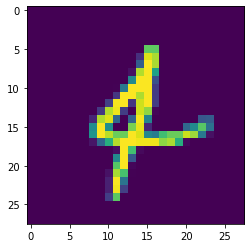

In [63]:
print(out_predict)
pred = out_predict.max(1, keepdim=True)[1]
print(pred)
plt.imshow(test_loader.dataset.data[image_index])
plt.show